In [1]:
# standard libraries
import re
from pathlib import Path
import sys
from datetime import datetime
import itertools
import warnings

# data science libraries
import pandas as pd
from scipy import stats
import numpy as np
import xarray as xr

# plotting libraries
import matplotlib.pyplot as plt
from matplotlib import colors

# progress bar for long computations
from tqdm.notebook import tqdm, trange

# for computing reference SW radiation
import solarpy

# parallelized computation
from dask.distributed import Client
from dask import distributed
from dask_jobqueue import SLURMCluster
from dask import array as da
from dask import dataframe as ddf
from dask import bag
import dask

# spatial libraries
import rasterio
import rioxarray as rxr
import geopandas as gpd
from rasterstats import zonal_stats
import shapely

# flux footprint analysis
from FFP_Python.calc_footprint_FFP_climatology import FFP_climatology
from FFP_Python.calc_footprint_FFP import FFP

In [3]:
postfire_dir = Path('/project/bbtrees/afox18/Platinum-EddyPro7/ExpectedOutputs/Chimney/All_CP')
postfire_FM20_dir = Path('/project/bbtrees/afox18/Platinum-EddyPro7/ExpectedOutputs/Chimney/All_CP_fm20')
postfire_noburb_dir = Path('/project/bbtrees/afox18/Platinum-EddyPro7/ExpectedOutputs/Chimney/All_CP_no_wpl')
prefire_dir = data_dir = Path('/project/bbtrees/afox18/Platinum-EddyPro7/ExpectedOutputs/Chimney/Prefire_full')

Import treatment data: we import a shapefile containing the fire treatments, then add another multipolygon containing all the areas that experienced no fire.

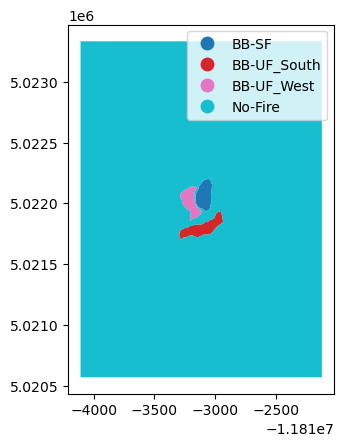

In [7]:
cpk_treatments = gpd.read_file("cpk_fire_treatments").to_crs(epsg=3857)
new_geo = []
for p in cpk_treatments.geometry:
    lines = [xy[:2] for xy in list(p.exterior.coords)]
    new_p = shapely.Polygon(lines)
    new_geo.append(new_p)
cpk_treatments.geometry = new_geo

west = -11813313.764467672 - 397*2
east = -11812915.891148828 + 397*2
south = 5021673.922043035 - 553*2
north = 5022226.998679176 + 553*2
everything_else = shapely.Polygon([
    (west, south),
    (west, north),
    (east, north),
    (east, south),
]).difference(cpk_treatments.dissolve().geometry[0])

cpk_treatments = pd.concat([
    cpk_treatments,
    gpd.GeoDataFrame(dict(Name=["No-Fire"], geometry=[everything_else])).set_crs(cpk_treatments.crs)
])
cpk_treatments.plot(column="Name", legend=True);

Analyze the footprint: determine the degree of "contamination" for each footpring

In [8]:
centers = {
    'BB-NF-3m':(-11813141.1316532, 5022171.8894318), 
    'BB-NF-17m':(-11813120.751769, 5022156.092396),
    'BB-SF-7m':(-11813067.99382776, 5022039.66075915),
    'BB-SF-4m':(-11813067.99382776, 5022039.66075915),
    'BB-UF-3m':(-11813112.2232494, 5021795.3050715),
}
zones_dict = {
    'BB-NF-3m':[
        cpk_treatments.query("Name == 'BB-SF'").geometry, # exclude
        cpk_treatments.query("Name == 'BB-UF_West'").geometry, # exclude
        cpk_treatments.query("Name == 'BB-UF_South'").geometry # exclude
    ], 
    'BB-SF-4m':[cpk_treatments.query("Name == 'BB-SF'").geometry],  # include
    'BB-UF-3m':[cpk_treatments.query("Name == 'BB-UF_West'").geometry, cpk_treatments.query("Name == 'BB-UF_South'").geometry]  # include
}

In [9]:
def compute_single_overlap(
    x:np.array, y:np.array, zm:float, umean:float, h:float, ol:float, sigmav:float, ustar:float, wind_dir:float,
    site_xy:tuple[float, float],
    zones:list[gpd.geoseries.GeoSeries],
    return_footprint=False,
):
    """
    given a set of "exclusion zones" (regions that we want to exclude from the footprint), a footprint location, and footprint contribution data, compute the degree of contamination

    x, y, zm, umean, h, ol, sigmav, ustar, wind_dir: data needed to compute the footprint model
    site_xy: xy coordinates to place the footprint in the exclusion zone. must be in the same CRS as the exclusion zones
    zones: iterable of geopandas geoseries showing the regions we are interested in computing the overlap for.
    """
    assert len(x) % 2 == 0, "X must be of even length"
    assert len(y) % 2 == 0, "Y must be of even length"
    
    # compute 2d footprint raster
    FFP_climatology_kwargs = dict(
        nx=x.shape[0], ny=y.shape[0],
        dx=x[1]-x[0], dy=y[1]-y[0],
        crop=1,
        rs=0.9,#[0.5, 0.75, 0.9],
        verbosity=0,
    )
    try:
        footprint = FFP_climatology(
            zm=zm,
            umean=umean,
            h=h,
            ol=ol,
            sigmav=sigmav,
            ustar=ustar,
            wind_dir=wind_dir,
            **FFP_climatology_kwargs,
        )
        success = True
    except:
        print(zm, umean, h, ol, sigmav, ustar, wind_dir)
        success = False

    if success:
        # transform footprint raster to sit on top of site of interest
        transform = rasterio.transform.from_origin(
            west=site_xy[0] + footprint["x_2d"][0,0],
            north=site_xy[1] + footprint["y_2d"][-1, -1],
            xsize=FFP_climatology_kwargs["dx"],
            ysize=FFP_climatology_kwargs["dy"],
        )
    
        # compute overlap between footprint and zone of interest
        f_interference = 0
        total_footprint = footprint["fclim_2d"].sum()
        for zone in zones:
            zone_interference = zonal_stats(
                vectors=zone, 
                # vectors=shapely.Polygon([(ix+site_xy[0], iy+site_xy[1]) for ix, iy in zip(footprint["xr"][2], footprint["yr"][2])]),
                raster=footprint["fclim_2d"], 
                stats='sum',
                affine=transform,
            )[0]["sum"]
            if zone_interference is not None:
                f_interference += zone_interference
        overlap = f_interference/total_footprint
        
        if return_footprint: 
            return overlap, footprint
        return overlap
    if return_footprint:
        return np.nan, None
    return np.nan
    
def compute_multiple_overlaps(
    x:np.array, y:np.array, 
    zm:list[float], umean:list[float], h:list[float], ol:list[float], sigmav:list[float], ustar:list[float], wind_dir:list[float],
    site_xy:tuple[float, float],
    zones:list[gpd.geoseries.GeoSeries],
):
    args = np.stack((zm, umean, h, ol, sigmav, ustar, wind_dir), axis=1)
    futures = client.map(
        lambda args: compute_single_overlap(
            x, y, 
            *args, 
            site_xy=site_xy, 
            zones=zones
        ),
        args
    )
    overlaps = client.gather(futures)
    return overlaps

# BB-NF 3m

In [3]:
flist = list(postfire_dir.glob("BB-NF-3m*/*full_output*.csv"))
data = pd.concat([
    pd.read_csv(f, na_values=-9999, skiprows=[0, 2])
    for f in flist
])
data["TIMESTAMP"] = pd.to_datetime(data["date"] + " " + data["time"])

data = data.dropna(subset=["wind_speed", "L", "v_var", "u*", "wind_dir"], how="any")

data["zm"] = 3

zm = data["zm"]
umean = data["wind_speed"]
ol = data["L"]
sigmav = np.sqrt(data["v_var"])
ustar = data["u*"]
wind_dir = data["wind_dir"]

In [7]:
try: cluster.close()
except (NameError, AttributeError): pass
try: client.shutdown()
except (NameError, AttributeError): pass

portdash = 8787
# 200 workers submitted as 10 jobs of 10 workers and 20 cores each (20/10=1 core per worker) 
cluster = SLURMCluster(
    account='bbtrees', 
    cores=20,
    memory="16GB", 
    walltime="1:00:00",
    scheduler_options={"dashboard_address": f":{portdash}"},
)
cluster.scale(jobs=10)
client = Client(cluster)
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.198.65.1:8787/status,
Dashboard: http://10.198.65.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.198.65.1:36495,Workers: 0
Dashboard: http://10.198.65.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [12]:
site = "BB-NF-3m"
i = data.shape[0]
zm = data["zm"].values[:i]
umean = data["wind_speed"].values[:i]
ol = data["L"].values[:i]
sigmav = np.sqrt(data["v_var"]).values[:i]
ustar = data["u*"].values[:i]
wind_dir = data["wind_dir"].values[:i]
h = [800]*len(zm)

overlaps = compute_multiple_overlaps(
    x=np.linspace(-500, 500, 1000), y=np.linspace(-500, 500, 1000),
    zm=zm, 
    umean=umean, 
    h=h, 
    ol=ol, 
    sigmav=sigmav, 
    ustar=ustar,
    wind_dir=wind_dir, 
    site_xy=centers[site],
    zones=zones_dict[site],
)
overlaps

t1 = timer()
print(t1 - t0)
# for i in range(30):
#     compute_single_overlap(
#         x=np.linspace(-500, 500, 1000), y=np.linspace(-500, 500, 1000),
#         zm=zm[i], 
#         umean=umean[i], 
#         h=h[i], 
#         ol=ol[i], 
#         sigmav=sigmav[i], 
#         ustar=ustar[i],
#         wind_dir=wind_dir[i], 
#         site_xy=centers[site],
#         zones=zones_dict[site],
#     )

243.66414057600014


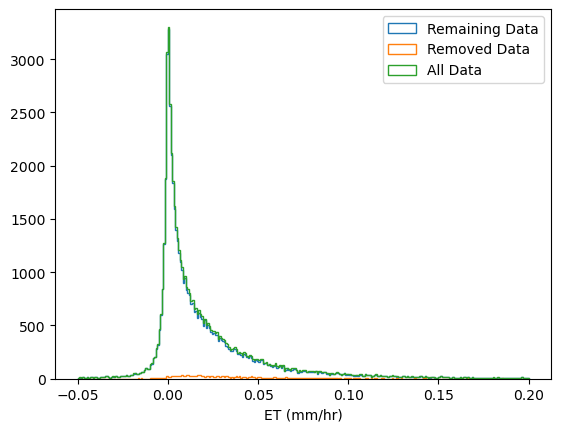

In [16]:
# filter the data: if the FFP model returns no footprint estimate, assume it's fine.
overlap_desired = False
max_contamination = 0.15
if overlap_desired:
    valid_footprint_index = np.where((np.asarray(overlaps) >= 1 - max_contamination) | (np.isnan(overlaps)))[0]
else:
    valid_footprint_index = np.where((np.asarray(overlaps) <= max_contamination) | (np.isnan(overlaps)))[0]

data.iloc[valid_footprint_index].to_csv(f"filtered_footprints/{site}_filtered_footprint.csv")
plt.hist(data.iloc[valid_footprint_index]["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="Remaining Data");
plt.hist(data.iloc[np.setdiff1d(np.arange(data.shape[0]), valid_footprint_index)]["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="Removed Data");
plt.hist(data["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="All Data");
plt.xlabel("ET (mm/hr)")
plt.legend()

In [17]:
cluster.close()
client.shutdown()

# BB-SF 4m

In [4]:
flist = list(postfire_dir.glob("BB-SF-4m*/*full_output*.csv"))
data = pd.concat([
    pd.read_csv(f, na_values=-9999, skiprows=[0, 2])
    for f in flist
])
data["TIMESTAMP"] = pd.to_datetime(data["date"] + " " + data["time"])

data = data.dropna(subset=["wind_speed", "L", "v_var", "u*", "wind_dir"], how="any")

data["zm"] = 3

zm = data["zm"]
umean = data["wind_speed"]
ol = data["L"]
sigmav = np.sqrt(data["v_var"])
ustar = data["u*"]
wind_dir = data["wind_dir"]

data

,filename,date,time,DOY,daytime,file_records,used_records,Tau,qc_Tau,H,...,w/co2_cov,w/h2o_cov,anemometer_diagnostic_mean,anemometer_diagnostic_mean.1,air_t_mean,air_p_mean,anemometer_diagnostic_mean.2,anemometer_diagnostic_mean.3,TIMESTAMP,zm
0,2019_01_01_0000.dat,2019-01-01,00:30,1.020,0.0,18000.0,17146.0,-0.018467,0.0,-11.76880,...,0.005544,-0.054656,0.0,0.0,249.022,72146.6,0.342539,0.357357,2019-01-01 00:30:00,3
1,2019_01_01_0000.dat,2019-01-01,01:00,1.041,0.0,18000.0,17610.0,-0.012116,0.0,-15.31960,...,0.012156,-0.124725,0.0,0.0,248.312,72145.6,0.319232,0.337204,2019-01-01 01:00:00,3
2,2019_01_01_0000.dat,2019-01-01,01:30,1.062,0.0,18000.0,17497.0,0.001154,1.0,1.31179,...,-0.001839,0.022866,0.0,0.0,247.402,72142.7,0.305051,0.324866,2019-01-01 01:30:00,3
21,2019_01_01_0000.dat,2019-01-01,11:00,1.458,1.0,18000.0,17820.0,-0.067486,0.0,30.36160,...,0.125885,-0.838790,0.0,0.0,261.696,72145.1,0.666326,0.627396,2019-01-01 11:00:00,3
22,2019_01_01_0000.dat,2019-01-01,11:30,1.479,1.0,18000.0,17671.0,-0.104132,0.0,40.68990,...,-0.002783,0.050780,0.0,0.0,262.409,72118.8,0.902339,0.815481,2019-01-01 11:30:00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5056,2023_09_22_0000.dat,2023-09-22,08:30,265.354,1.0,18000.0,15336.0,-0.345455,0.0,83.45760,...,-0.007455,0.802187,0.0,0.0,282.540,73015.3,0.898853,0.818863,2023-09-22 08:30:00,3
5057,2023_09_22_0000.dat,2023-09-22,09:00,265.375,1.0,18000.0,15599.0,-0.232208,0.0,130.98100,...,-0.010689,0.821616,0.0,0.0,283.596,73022.6,0.900322,0.820544,2023-09-22 09:00:00,3
5058,2023_09_22_0000.dat,2023-09-22,09:30,265.396,1.0,18000.0,15281.0,-0.476812,0.0,166.40000,...,-0.012660,0.934649,0.0,0.0,284.366,73023.4,0.899674,0.819739,2023-09-22 09:30:00,3
5059,2023_09_22_0000.dat,2023-09-22,10:00,265.417,1.0,18000.0,15534.0,-0.311171,1.0,174.12500,...,-0.014233,0.981974,0.0,0.0,284.491,73019.8,0.898280,0.817927,2023-09-22 10:00:00,3


In [5]:
try: cluster.close()
except (NameError, AttributeError): pass
try: client.shutdown()
except (NameError, AttributeError): pass

portdash = 8787
# 200 workers submitted as 10 jobs of 10 workers and 20 cores each (20/10=1 core per worker) 
cluster = SLURMCluster(
    account='bbtrees', 
    cores=20,
    memory="16GB", 
    walltime="1:00:00",
    scheduler_options={"dashboard_address": f":{portdash}"},
)
cluster.scale(jobs=10)
client = Client(cluster)
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.198.65.7:8787/status,
Dashboard: http://10.198.65.7:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.198.65.7:34275,Workers: 0
Dashboard: http://10.198.65.7:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
site = "BB-SF-4m"
i = data.shape[0]
zm = data["zm"].values[:i]
umean = data["wind_speed"].values[:i]
ol = data["L"].values[:i]
sigmav = np.sqrt(data["v_var"]).values[:i]
ustar = data["u*"].values[:i]
wind_dir = data["wind_dir"].values[:i]
h = [800]*len(zm)

overlaps = compute_multiple_overlaps(
    x=np.linspace(-500, 500, 1000), y=np.linspace(-500, 500, 1000),
    zm=zm, 
    umean=umean, 
    h=h, 
    ol=ol, 
    sigmav=sigmav, 
    ustar=ustar,
    wind_dir=wind_dir, 
    site_xy=centers[site],
    zones=zones_dict[site],
)
# overlaps
# for i in range(30):
#     compute_single_overlap(
#         x=np.linspace(-500, 500, 1000), y=np.linspace(-500, 500, 1000),
#         zm=zm[i], 
#         umean=umean[i], 
#         h=h[i], 
#         ol=ol[i], 
#         sigmav=sigmav[i], 
#         ustar=ustar[i],
#         wind_dir=wind_dir[i], 
#         site_xy=centers[site],
#         zones=zones_dict[site],
#     )

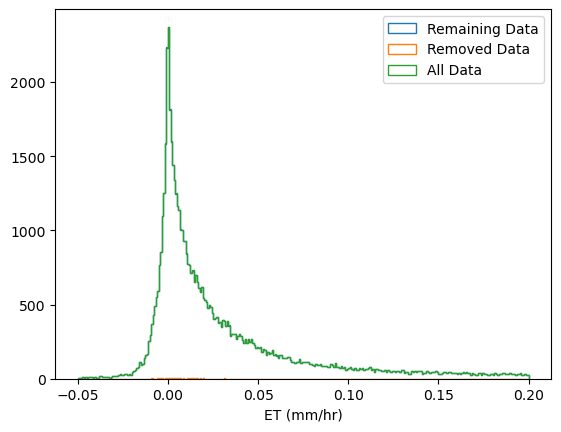

In [11]:
# filter the data: if the FFP model returns no footprint estimate, assume it's fine.
overlap_desired = True
max_contamination = 0.15
if overlap_desired:
    valid_footprint_index = np.where((np.asarray(overlaps) >= 1 - max_contamination) | (np.isnan(overlaps)))[0]
else:
    valid_footprint_index = np.where((np.asarray(overlaps) <= max_contamination) | (np.isnan(overlaps)))[0]

data.iloc[valid_footprint_index].to_csv(f"filtered_footprints/{site}_filtered_footprint.csv")
plt.hist(data.iloc[valid_footprint_index]["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="Remaining Data");
plt.hist(data.iloc[np.setdiff1d(np.arange(data.shape[0]), valid_footprint_index)]["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="Removed Data");
plt.hist(data["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="All Data");
plt.xlabel("ET (mm/hr)")
plt.legend()

In [12]:
cluster.close()
client.shutdown()

# BB-UF 3m

In [13]:
flist = list(postfire_dir.glob("BB-UF-3m*/*full_output*.csv"))
data = pd.concat([
    pd.read_csv(f, na_values=-9999, skiprows=[0, 2])
    for f in flist
])
data["TIMESTAMP"] = pd.to_datetime(data["date"] + " " + data["time"])

data = data.dropna(subset=["wind_speed", "L", "v_var", "u*", "wind_dir"], how="any")

data["zm"] = 3

zm = data["zm"]
umean = data["wind_speed"]
ol = data["L"]
sigmav = np.sqrt(data["v_var"])
ustar = data["u*"]
wind_dir = data["wind_dir"]

In [14]:
try: cluster.close()
except (NameError, AttributeError): pass
try: client.shutdown()
except (NameError, AttributeError): pass

portdash = 8787
# 200 workers submitted as 10 jobs of 10 workers and 20 cores each (20/10=1 core per worker) 
cluster = SLURMCluster(
    account='bbtrees', 
    cores=20,
    memory="16GB", 
    walltime="1:00:00",
    scheduler_options={"dashboard_address": f":{portdash}"},
)
cluster.scale(jobs=10)
client = Client(cluster)
display(client)

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://10.198.65.7:8787/status,
Dashboard: http://10.198.65.7:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.198.65.7:42197,Workers: 0
Dashboard: http://10.198.65.7:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [15]:
site = "BB-UF-3m"
i = data.shape[0]
zm = data["zm"].values[:i]
umean = data["wind_speed"].values[:i]
ol = data["L"].values[:i]
sigmav = np.sqrt(data["v_var"]).values[:i]
ustar = data["u*"].values[:i]
wind_dir = data["wind_dir"].values[:i]
h = [800]*len(zm)

overlaps = compute_multiple_overlaps(
    x=np.linspace(-500, 500, 1000), y=np.linspace(-500, 500, 1000),
    zm=zm, 
    umean=umean, 
    h=h, 
    ol=ol, 
    sigmav=sigmav, 
    ustar=ustar,
    wind_dir=wind_dir, 
    site_xy=centers[site],
    zones=zones_dict[site],
)
overlaps

# for i in range(30):
#     compute_single_overlap(
#         x=np.linspace(-500, 500, 1000), y=np.linspace(-500, 500, 1000),
#         zm=zm[i], 
#         umean=umean[i], 
#         h=h[i], 
#         ol=ol[i], 
#         sigmav=sigmav[i], 
#         ustar=ustar[i],
#         wind_dir=wind_dir[i], 
#         site_xy=centers[site],
#         zones=zones_dict[site],
#     )

NameError: name 'timer' is not defined

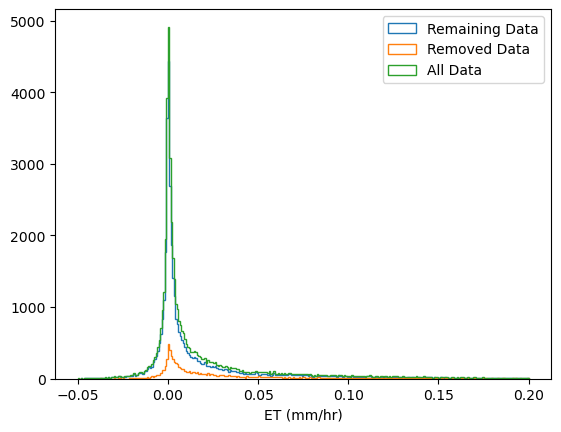

In [16]:
# filter the data: if the FFP model returns no footprint estimate, assume it's fine.
overlap_desired = True
max_contamination = 0.15
if overlap_desired:
    valid_footprint_index = np.where((np.asarray(overlaps) >= 1 - max_contamination) | (np.isnan(overlaps)))[0]
else:
    valid_footprint_index = np.where((np.asarray(overlaps) <= max_contamination) | (np.isnan(overlaps)))[0]

data.iloc[valid_footprint_index].to_csv(f"filtered_footprints/{site}_filtered_footprint.csv")
plt.hist(data.iloc[valid_footprint_index]["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="Remaining Data");
plt.hist(data.iloc[np.setdiff1d(np.arange(data.shape[0]), valid_footprint_index)]["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="Removed Data");
plt.hist(data["ET"], bins=np.linspace(-0.05, 0.2, 301), density=False, histtype="step", label="All Data");
plt.xlabel("ET (mm/hr)")
plt.legend()

In [17]:
cluster.close()
client.shutdown()